In [1]:
from collections import defaultdict
from itertools import islice, product
import random
import time
from pathlib import Path

import numpy as np
from tqdm.auto import tqdm

import pandas as pd
from sympy import parse_expr, lambdify

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

In [2]:
# plt.rcParams.update({"text.usetex": True}) 

In [3]:
def parameters(width, depth, dimension):
    """Computes number of parameters in MLP with widths `width`,
    depth `depth`, and input dimension `dimension`. Assumes the neurons
    have biases.
    """
    return (dimension * width + width) + (depth - 2)*(width * width + width) + (width + 1)

def width_given_ddp(depth, dimension, parameters):
    """Given the network depth and input dimension, computes the
    width such that the architecture (with bias) has `parameters` parameters.
    """
    if depth == 2:
        return int((parameters - 1) / (dimension + 2))
    root = (-(dimension + depth) + np.sqrt(np.power(dimension + depth, 2) - 4 * (depth - 2) * (1 - parameters))) / (2 * (depth - 2))
    return int(root)

def create_normalizer(mean, std):
    """Create a function to normalize data of the form (N, d) given the means
    and stds along each of the d columns.

    Args:
        mean: (mean[1], ..., mean[d])
        std: (std[1], ..., std[d])
    """
    assert len(mean) == len(std)
    def normalize(x):
        return torch.stack([(x[:, i] - mean[i]) / std[i] for i in range(len(mean))], dim=1)
    return normalize

In [4]:
results = dict()

In [5]:
width = 5
depth = 3
lr = 1e-3
activation = 'ReLU'
N_TEST_POINTS = 30000
TEST_COMPACTIFICATION = 0.8
MAX_TRAIN_ITERS = 25000
MAX_BATCH_SIZE = 30000

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64
seed = 1

torch.set_default_dtype(dtype)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)


target = lambda x: np.cos(2*x)
ranges = [(3, 6)]
dimension = 1

TRAIN_POINTS = parameters(width, depth, dimension) // (dimension + 1)


# create datasets
ls = np.array([ranges[i][0] for i in range(dimension)])
hs = np.array([ranges[i][1] for i in range(dimension)])
xs_train = np.random.uniform(low=ls, high=hs, size=(TRAIN_POINTS, dimension))
ys_train = target(*[xs_train[:, i] for i in range(dimension)])

cs = (hs + ls) / 2
ws = (hs - ls) * TEST_COMPACTIFICATION
ls, hs = cs - ws / 2, cs + ws / 2
xs_test = np.random.uniform(low=ls, high=hs, size=(N_TEST_POINTS, dimension))
ys_test = target(*[xs_test[:, i] for i in range(dimension)])

xs_train = torch.from_numpy(xs_train).to(device)
ys_train = torch.from_numpy(ys_train).to(device).unsqueeze(dim=1)
xs_test = torch.from_numpy(xs_test).to(device)
ys_test = torch.from_numpy(ys_test).to(device).unsqueeze(dim=1)

if activation == 'ReLU':
    activation_fn = nn.ReLU
elif activation == 'Tanh':
    activation_fn = nn.Tanh
elif activation == 'Sigmoid':
    activation_fn = nn.Sigmoid
else:
    assert False, f"Unrecognized activation function identifier: {activation}"

# create model
layers = []
for i in range(depth):
    if i == 0:
        layers.append(nn.Linear(dimension, width))
        layers.append(activation_fn())
    elif i == depth - 1:
        layers.append(nn.Linear(width, 1))
    else:
        layers.append(nn.Linear(width, width))
        layers.append(activation_fn())
mlp = nn.Sequential(*layers).to(device)

loss_fn = nn.MSELoss()
optim = torch.optim.Adam(mlp.parameters(), lr=lr)

results[0] = dict()
results[0]['train'] = list()
results[0]['test'] = list()

k = 0
for step in tqdm(range(MAX_TRAIN_ITERS)):    
    with torch.no_grad():
        train_l = torch.sqrt(torch.mean(torch.pow(mlp(xs_train) - ys_train, 2))).item()
        test_l = torch.sqrt(torch.mean(torch.pow(mlp(xs_test) - ys_test, 2))).item()
        if step % 100 == 0:
            results[0]['train'].append(train_l)
            results[0]['test'].append(test_l)
    optim.zero_grad()
    ys_pred = mlp(xs_train)
    l = loss_fn(ys_train, ys_pred)
    l.backward()
    optim.step()
results[0]['mlp'] = mlp

# create model
layers = []
for i in range(depth):
    if i == 0:
        layers.append(nn.Linear(dimension, width))
        layers.append(activation_fn())
    elif i == depth - 1:
        layers.append(nn.Linear(width, 1))
    else:
        layers.append(nn.Linear(width, width))
        layers.append(activation_fn())
mlp = nn.Sequential(*layers).to(device)

normalize = create_normalizer(xs_train.mean(dim=0), xs_train.std(dim=0))
xs_train_normalized = normalize(xs_train)
xs_test_normalized = normalize(xs_test)

loss_fn = nn.MSELoss()
optim = torch.optim.Adam(mlp.parameters(), lr=lr)

results[1] = dict()
results[1]['train'] = list()
results[1]['test'] = list()

k = 0
for step in tqdm(range(MAX_TRAIN_ITERS)):    
    with torch.no_grad():
        train_l = torch.sqrt(torch.mean(torch.pow(mlp(xs_train_normalized) - ys_train, 2))).item()
        test_l = torch.sqrt(torch.mean(torch.pow(mlp(xs_test_normalized) - ys_test, 2))).item()
        if step % 100 == 0:
            results[1]['train'].append(train_l)
            results[1]['test'].append(test_l)
    optim.zero_grad()
    ys_pred = mlp(xs_train_normalized)
    l = loss_fn(ys_train, ys_pred)
    l.backward()
    optim.step()
results[1]['mlp'] = mlp

from scipy import spatial, interpolate
f = interpolate.interp1d(xs_train.reshape((TRAIN_POINTS,)).cpu().detach().cpu().numpy(), ys_train.reshape((TRAIN_POINTS,)).detach().cpu().numpy(), kind='linear', bounds_error=False)
preds = f(xs_test.reshape((N_TEST_POINTS,)).detach().cpu().numpy())
valid_idx = ~np.isnan(preds)
rmse_loss = np.sqrt(np.mean(np.power(preds[valid_idx] - ys_test.reshape((N_TEST_POINTS,)).detach().cpu().numpy()[valid_idx], 2)))
results[2] = dict()
results[2]['loss'] = rmse_loss
results[2]['f'] = f


  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

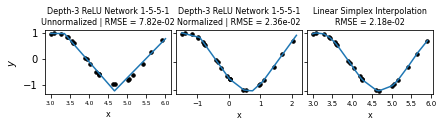

In [11]:
plt.figure(figsize=(6, 1.6))
xs_plots = np.linspace(ranges[0][0], ranges[0][1], 100000).reshape((100000, 1))
xs_plots = torch.from_numpy(xs_plots).to(device)
# ys_network = mlp(xs_plots)
# ys_simplex = results[depth]['f'](xs_plots.detach().cpu().numpy())
for i in [0, 1]:
    plt.subplot(1, 3, i+1)
    if i == 0:
        plt.plot(xs_plots.detach().cpu().numpy(), results[i]['mlp'](xs_plots).detach().cpu().numpy())
        plt.scatter(xs_train.detach().cpu().numpy(), ys_train.detach().cpu().numpy(), color='black', s=12)
        plt.title(f"Depth-3 ReLU Network 1-{(str(width)+'-')*(depth-1)}1\nUnnormalized | RMSE = {min(results[i]['test']):.2e}", fontsize=8)
        plt.ylabel("$y$")
        plt.xticks([3, 3.5, 4, 4.5, 5, 5.5, 6], fontsize=6)
    if i == 1:
        plt.plot(normalize(xs_plots).detach().cpu().numpy(), results[i]['mlp'](normalize(xs_plots)).detach().cpu().numpy())
        plt.scatter(normalize(xs_train).detach().cpu().numpy(), ys_train.detach().cpu().numpy(), color='black', s=12)
        # remove y axis ticklabels, but keep ticks
        plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
        plt.title(f"Depth-3 ReLU Network 1-{(str(width)+'-')*(depth-1)}1\nNormalized | RMSE = {min(results[i]['test']):.2e}", fontsize=8) 
        plt.xticks(fontsize=7)
    plt.xlabel("x", fontsize=8)

plt.subplot(1, 3, 3)
plt.plot(xs_plots.detach().cpu().numpy(), results[2]['f'](xs_plots.detach().cpu().numpy()))
plt.scatter(xs_train.detach().cpu().numpy(), ys_train.detach().cpu().numpy(), color='black', s=12)
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.title(f"Linear Simplex Interpolation\nRMSE = {results[2]['loss']:.2e}", fontsize=8) 
plt.xticks([3, 3.5, 4, 4.5, 5, 5.5, 6], fontsize=7)
plt.xlabel("x", fontsize=8)

# have subplots share a y axis, no space between subplots

plt.tight_layout(pad=0.1)
plt.savefig('../final-figures/1d-linear-regions-new.pdf')

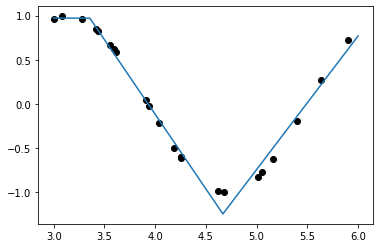

In [8]:
xs_plots = np.linspace(ranges[0][0], ranges[0][1], 100000).reshape((100000, 1))
xs_plots = torch.from_numpy(xs_plots).to(device)
# ys_network = mlp(xs_plots)
# ys_simplex = results[depth]['f'](xs_plots.detach().cpu().numpy())
plt.plot(xs_plots.detach().cpu().numpy(), mlp(xs_plots).detach().cpu().numpy())
plt.scatter(xs_train.detach().cpu().numpy(), ys_train.detach().cpu().numpy(), color='black')

In [9]:
width = 5
depth = 3
lr = 1e-3
activation = 'ReLU'
N_TEST_POINTS = 30000
TEST_COMPACTIFICATION = 0.8
MAX_TRAIN_ITERS = 25000
MAX_BATCH_SIZE = 30000

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64
seed = 1

torch.set_default_dtype(dtype)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)


target = lambda x: np.cos(2*x)
ranges = [(3, 6)]
dimension = 1

TRAIN_POINTS = parameters(width, depth, dimension) // (dimension + 1)

# create datasets
ls = np.array([ranges[i][0] for i in range(dimension)])
hs = np.array([ranges[i][1] for i in range(dimension)])
xs_train = np.random.uniform(low=ls, high=hs, size=(TRAIN_POINTS, dimension))
ys_train = target(*[xs_train[:, i] for i in range(dimension)])

cs = (hs + ls) / 2
ws = (hs - ls) * TEST_COMPACTIFICATION
ls, hs = cs - ws / 2, cs + ws / 2
xs_test = np.random.uniform(low=ls, high=hs, size=(N_TEST_POINTS, dimension))
ys_test = target(*[xs_test[:, i] for i in range(dimension)])

xs_train = torch.from_numpy(xs_train).to(device)
ys_train = torch.from_numpy(ys_train).to(device).unsqueeze(dim=1)
xs_test = torch.from_numpy(xs_test).to(device)
ys_test = torch.from_numpy(ys_test).to(device).unsqueeze(dim=1)

normalize = create_normalizer(xs_train.mean(dim=0), xs_train.std(dim=0))
xs_train = normalize(xs_train)
xs_test = normalize(xs_test)

if activation == 'ReLU':
    activation_fn = nn.ReLU
elif activation == 'Tanh':
    activation_fn = nn.Tanh
elif activation == 'Sigmoid':
    activation_fn = nn.Sigmoid
else:
    assert False, f"Unrecognized activation function identifier: {activation}"

# create model
layers = []
for i in range(depth):
    if i == 0:
        layers.append(nn.Linear(dimension, width))
        layers.append(activation_fn())
    elif i == depth - 1:
        layers.append(nn.Linear(width, 1))
    else:
        layers.append(nn.Linear(width, width))
        layers.append(activation_fn())
mlp = nn.Sequential(*layers).to(device)

loss_fn = nn.MSELoss()
optim = torch.optim.Adam(mlp.parameters(), lr=lr)

# ex.info['train'] = list()
train = list()
# ex.info['test'] = list()
test = list()
min_train = float('inf')
min_test = float('inf')
test_at_min_train = float('inf')

k = 0
for step in tqdm(range(MAX_TRAIN_ITERS)):    
    with torch.no_grad():
        train_l = torch.sqrt(torch.mean(torch.pow(mlp(xs_train) - ys_train, 2))).item()
        test_l = torch.sqrt(torch.mean(torch.pow(mlp(xs_test) - ys_test, 2))).item()
        if train_l < min_train:
            min_train = train_l
            test_at_min_train = test_l
        min_test = test_l if test_l < min_test else min_test
        if step % 100 == 0:
            # ex.info['train'].append(train_l)
            # ex.info['test'].append(test_l)
            train.append(train_l)
            test.append(test_l)
    optim.zero_grad()
    ys_pred = mlp(xs_train)
    l = loss_fn(ys_train, ys_pred)
    l.backward()
    optim.step()

# results[depth] = dict()
# results[depth]['test_at_min_train'] = test_at_min_train
# results[depth]['test'] = test
# results[depth]['train'] = train
# results[depth]['mlp'] = mlp
# results[depth]['f'] = f

  0%|          | 0/25000 [00:00<?, ?it/s]

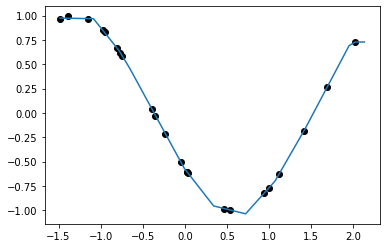

In [10]:
xs_plots = np.linspace(ranges[0][0], ranges[0][1], 100000).reshape((100000, 1))
xs_plots = torch.from_numpy(xs_plots).to(device)
xs_plots = normalize(xs_plots)
# ys_network = mlp(xs_plots)
# ys_simplex = results[depth]['f'](xs_plots.detach().cpu().numpy())
plt.plot(xs_plots.detach().cpu().numpy(), mlp(xs_plots).detach().cpu().numpy())
plt.scatter(xs_train.detach().cpu().numpy(), ys_train.detach().cpu().numpy(), color='black')

In [ ]:
eqn = 'Z.001'
# width = 30
# depth = 2
lr = 1e-3
activation = 'ReLU'
N_TEST_POINTS = 30000
TEST_COMPACTIFICATION = 0.8
MAX_TRAIN_ITERS = 25000
MAX_BATCH_SIZE = 30000
spreadsheet = "../../equations.csv"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64
seed = 0

depths = [2, 3, 4]
widths = [30, 8, 6]

results = dict()
for depth, width in zip(depths, widths):
    torch.set_default_dtype(dtype)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    equations = pd.read_csv(spreadsheet)
    row = equations[equations['Equation'] == eqn].iloc[0]
    dimension = int(row['# variables'])
    formula = row['Formula']
    variables = [row[f'v{i}_name'] for i in range(1, dimension+1)]
    ranges = [(row[f'v{i}_low'], row[f'v{i}_high']) for i in range(1, dimension+1)]
    target = lambdify(variables, parse_expr(formula))

    TRAIN_POINTS = parameters(width, depth, dimension) // (dimension + 1)
    # ex.info['TRAIN_POINTS'] = TRAIN_POINTS
    # _log.debug(f"TRAIN_POINTS: {TRAIN_POINTS}")

    # create datasets
    ls = np.array([ranges[i][0] for i in range(dimension)])
    hs = np.array([ranges[i][1] for i in range(dimension)])
    xs_train = np.random.uniform(low=ls, high=hs, size=(TRAIN_POINTS, dimension))
    ys_train = target(*[xs_train[:, i] for i in range(dimension)])

    cs = (hs + ls) / 2
    ws = (hs - ls) * TEST_COMPACTIFICATION
    ls, hs = cs - ws / 2, cs + ws / 2
    xs_test = np.random.uniform(low=ls, high=hs, size=(N_TEST_POINTS, dimension))
    ys_test = target(*[xs_test[:, i] for i in range(dimension)])

    xs_train = torch.from_numpy(xs_train).to(device)
    ys_train = torch.from_numpy(ys_train).to(device).unsqueeze(dim=1)
    xs_test = torch.from_numpy(xs_test).to(device)
    ys_test = torch.from_numpy(ys_test).to(device).unsqueeze(dim=1)
    
    ## Simplex interpolation first

    from scipy import spatial, interpolate

    # xs_train = xs_train.reshape((TRAIN_POINTS,))
    # ys_train = ys_train.reshape((TRAIN_POINTS,))
    # xs_test = xs_test.reshape((N_TEST_POINTS,))
    # ys_test = ys_test.reshape((N_TEST_POINTS,))

    f = interpolate.interp1d(xs_train.reshape((TRAIN_POINTS,)).cpu().detach().cpu().numpy(), ys_train.reshape((TRAIN_POINTS,)).detach().cpu().numpy(), kind='linear', bounds_error=False)

    # _log.debug("Evaluating model") 
    preds = f(xs_test.reshape((N_TEST_POINTS,)).detach().cpu().numpy())
    valid_idx = ~np.isnan(preds)
    rmse_loss = np.sqrt(np.mean(np.power(preds[valid_idx] - ys_test.reshape((N_TEST_POINTS,)).detach().cpu().numpy()[valid_idx], 2)))
    # ex.info['test'] = rmse_loss.item() 

    if activation == 'ReLU':
        activation_fn = nn.ReLU
    elif activation == 'Tanh':
        activation_fn = nn.Tanh
    elif activation == 'Sigmoid':
        activation_fn = nn.Sigmoid
    else:
        assert False, f"Unrecognized activation function identifier: {activation}"

    # create model
    layers = []
    for i in range(depth):
        if i == 0:
            layers.append(nn.Linear(dimension, width))
            layers.append(activation_fn())
        elif i == depth - 1:
            layers.append(nn.Linear(width, 1))
        else:
            layers.append(nn.Linear(width, width))
            layers.append(activation_fn())
    mlp = nn.Sequential(*layers).to(device)
    # _log.debug("Created model.")
    # _log.debug(f"Model has {sum(t.numel() for t in mlp.parameters())} parameters") 

    loss_fn = nn.MSELoss()
    optim = torch.optim.Adam(mlp.parameters(), lr=lr)

    # ex.info['train'] = list()
    train = list()
    # ex.info['test'] = list()
    test = list()
    min_train = float('inf')
    min_test = float('inf')
    test_at_min_train = float('inf')

    k = 0
    for step in tqdm(range(MAX_TRAIN_ITERS)):
        optim.zero_grad()
        if TRAIN_POINTS <= MAX_BATCH_SIZE:
            ys_pred = mlp(xs_train)
            l = loss_fn(ys_train, ys_pred)
        else:
            sample_idx = torch.arange(k, k+MAX_BATCH_SIZE, 1) % TRAIN_POINTS
            xs_batch, ys_batch = xs_train[sample_idx], ys_train[sample_idx]
            ys_pred = mlp(xs_batch)
            l = loss_fn(ys_batch, ys_pred)
            k += MAX_BATCH_SIZE
        l.backward()
        optim.step()
        with torch.no_grad():
            train_l = torch.sqrt(l).item()
            test_l = torch.sqrt(torch.mean(torch.pow(mlp(xs_test) - ys_test, 2))).item()
            if train_l < min_train:
                min_train = train_l
                test_at_min_train = test_l
            min_test = test_l if test_l < min_test else min_test
            if step % 100 == 0:
                # ex.info['train'].append(train_l)
                # ex.info['test'].append(test_l)
                train.append(train_l)
                test.append(test_l)
    
    results[depth] = dict()
    results[depth]['test_at_min_train'] = test_at_min_train
    results[depth]['test'] = test
    results[depth]['train'] = train
    results[depth]['mlp'] = mlp
    results[depth]['f'] = f

    